In [89]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
print('Tensorflow version should be at least 2: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version should be at least 2: 2.9.1


In [90]:
#Parameters
seq_len = 43 #19 ShortTerm; 43 MidTerm; 86 LongTerm
predict_column = 5
#
stock_file = 'stockData/000686.csv'
use_checkpoint_file = 'checkpoints/Transformer+TimeEmbedding_43_000686.hdf5'
preictLen = 2 #Length of test date for predict, -1 means this args is ignore ;0 means predict the next date, 1 means predict today and next date... 

In [91]:
##Load data
df = pd.read_csv(stock_file, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

df['Max_Close_Price_In_Next_N_Days'] = df['close'].rolling(20).max().shift(-19)
df['Close_Price_After_N_Days'] = df['close'].shift(-19)

df['Max_Close_Diff'] = df['Max_Close_Price_In_Next_N_Days'] - df['close']
df['Close_Diff'] = df['Close_Price_After_N_Days'] - df['close']

df['Result'] = 0
df.loc[(df['Max_Close_Diff'] > 0) & (df['Close_Diff'] > 0), ['Result']] = 1

del df['Max_Close_Diff']
del df['Close_Diff']
del df['Close_Price_After_N_Days']
del df['Max_Close_Price_In_Next_N_Days']

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.tail()

,date,open,high,low,close,volume,Result
5398,2023-06-19,7.436,7.515,7.365,7.435,233291.5,0
5399,2023-06-20,7.441,7.516,7.379,7.449,231528.6,0
5400,2023-06-21,7.438,7.508,7.360,7.423,249717.1,0
5401,2023-06-26,7.400,7.455,7.307,7.359,261775.7,0
5402,9999-01-01,7.343,7.387,7.234,7.274,252525.2,0


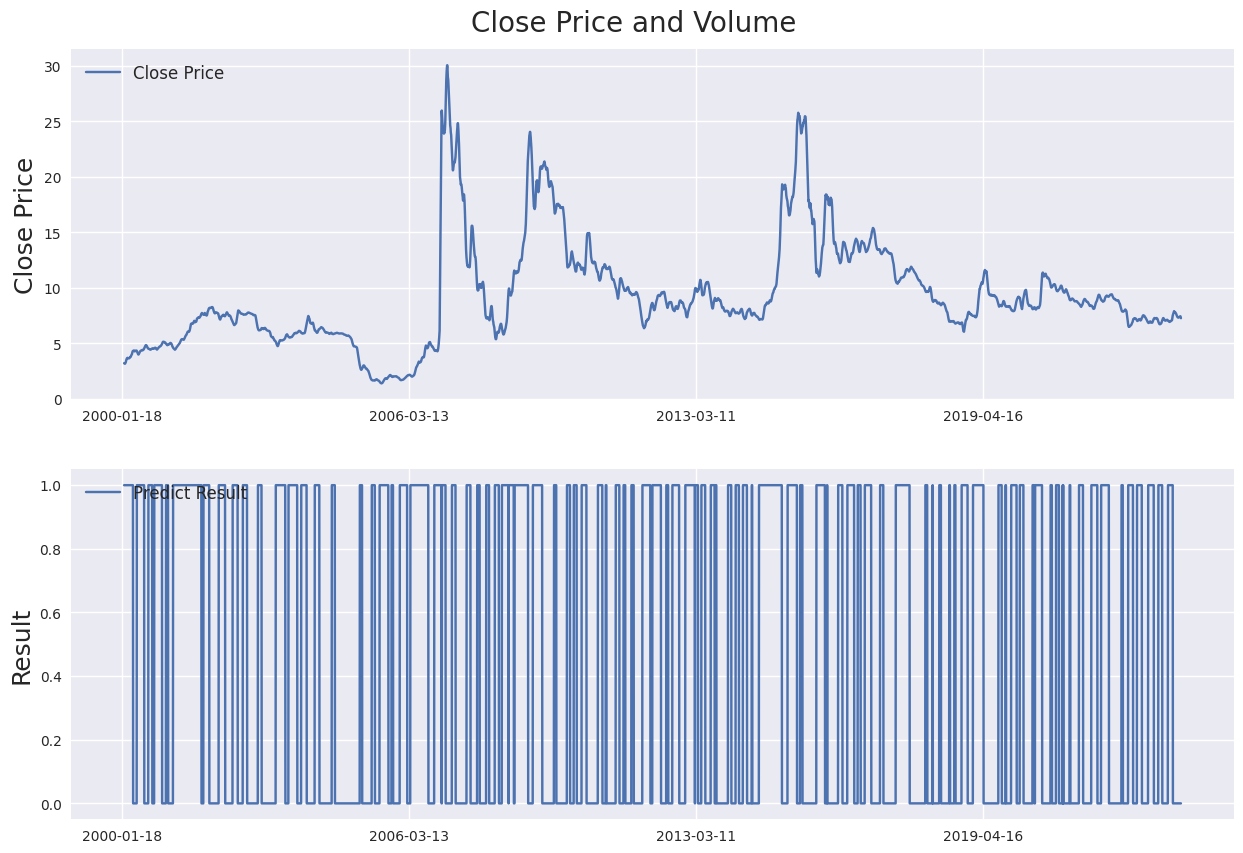

In [92]:
#Plot daily closing prices and volume
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['close'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Result'], label='Predict Result')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['date'].loc[::1464])
ax2.set_ylabel('Result', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
plt.show()

In [93]:
#Calculate normalized percentage change for all columns
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Result column'''

min_result = df[(df.index < last_20pct)]['Result'].min(axis=0)
max_result = df[(df.index < last_20pct)]['Result'].max(axis=0)

# Min-max normalize Result columns (0-1 range)
#It seams if result is either 0 or 1, then it does not need normalize
df['Result'] = (df['Result'] - min_result) / (max_result - min_result)
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]

#self.seq_len + self.preictLen + 1: the last +1 is for the prediction date
df_test = df[-(seq_len + preictLen + 1):]
df_test_with_date = df[-(seq_len + preictLen + 1):]                                          

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
test_data_with_date = df_test_with_date.values
df_test_with_date=df_test_with_date[-(len(df_test_with_date)-seq_len):]

print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.tail()
#print(test_data)
#print('=====================')
#print(df_test_with_date)

Training data shape: (4315, 6)
Validation data shape: (539, 6)
Test data shape: (46, 6)


,open,high,low,close,volume,Result
4320,0.111296,0.114916,0.112508,0.122595,0.046681,0.0
4321,0.124148,0.113725,0.111573,0.102184,0.046329,0.0
4322,0.100336,0.089656,0.100974,0.094496,0.041183,0.0
4323,0.106699,0.098726,0.101225,0.098044,0.044653,0.0
4324,0.100540,0.099242,0.107463,0.110342,0.043986,0.0


In [94]:
#Create chunks of training, validation, and test data
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, predict_column][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, predict_column][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
X_test_with_data, X_test_last_43 = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    X_test_with_data.append(test_data_with_date[i-seq_len:i])
    y_test.append(test_data[:, predict_column][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

X_test_with_data = np.array(X_test_with_data)
X_test_last_43 = X_test[-1:]
X_test_with_date_last_43 = X_test_with_data[-1:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(X_train[-1:])
print(y_train[-1:])

(4272, 43, 6) (4272,)
(496, 43, 6) (496,)
(3, 43, 6) (3,)
[[[0.12399868 0.12318524 0.12230245 0.12115286 0.05003369 0.        ]
  [0.12011062 0.11865489 0.12086173 0.11938794 0.04792514 0.        ]
  [0.1169586  0.11760879 0.11348128 0.11313102 0.05094764 1.        ]
  [0.11486804 0.11485001 0.11593269 0.11417111 0.04775035 1.        ]
  [0.11590823 0.11210036 0.11557961 0.11139828 0.04624921 1.        ]
  [0.10688956 0.10282001 0.08936909 0.08642755 0.05613062 1.        ]
  [0.08601373 0.08482525 0.07783539 0.07911073 0.05265464 1.        ]
  [0.08148204 0.07819724 0.07515573 0.0711467  0.04805185 1.        ]
  [0.07321601 0.0751963  0.0687165  0.06785926 0.04937878 1.        ]
  [0.07108691 0.07026014 0.06861572 0.06993684 0.04730425 1.        ]
  [0.06922566 0.06947551 0.06814716 0.06838825 0.0486706  1.        ]
  [0.0638919  0.07277224 0.06304441 0.07213105 0.05052824 1.        ]
  [0.07858958 0.09602544 0.0808603  0.10260429 0.0567671  1.        ]
  [0.11274158 0.11351389 0.09916

In [95]:
#Load pre-train model
from model.transformer import TransformerEncoder
from model.transformer import Time2Vector
from model.transformer import MultiAttention
from model.transformer import SingleAttention
       
model = tf.keras.models.load_model(use_checkpoint_file,
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

test_pred = model.predict(X_test)

1/1 [==============================] - 4s 4s/step


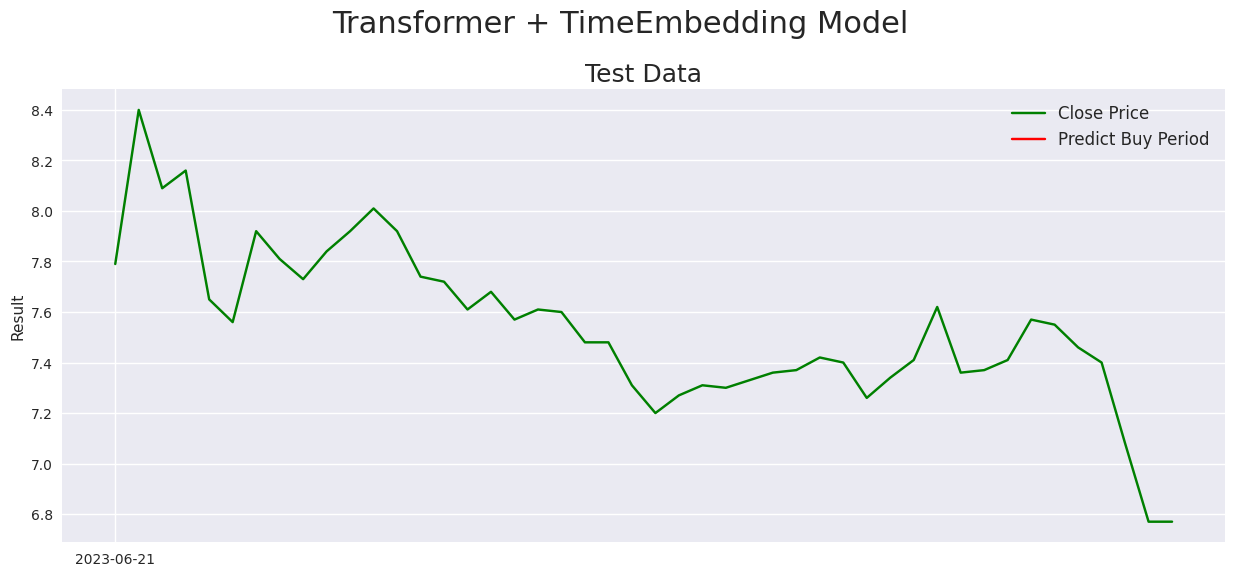

In [96]:
###############################################################################
'''Display results'''

df2 = pd.read_csv(stock_file, delimiter=',', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])
df2.sort_values('date', inplace=True)
df2_close = df2['close'].values

df2_test_close_price   = df2_close[-len(test_data):]
df2_val_close_price    = df2[(df2.index >= last_20pct) & (df2.index < last_10pct)]['close'].values
df2_train_close_price  = df2[(df2.index < last_20pct)]['close'].values
####

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model ", fontsize=22)
st.set_y(0.92)

#Plot test data results
ax11 = fig.add_subplot(311)
ax11.plot(df2_test_close_price, label='Close Price', color='g')

df2_test_close_price_4_show = df2_test_close_price[-(len(df2_test_close_price)-seq_len):]
states_buy = []
index = 0
for pred in test_pred:
    if pred >= 0.75:
        states_buy.append(df2_test_close_price_4_show[index])
    else:
        states_buy.append(None)
    index += 1    

ax11.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), states_buy, label='Predict Buy Period', color='r')

#
ax11.set_title("Test Data", fontsize=18)
#ax11.set_xlabel('date')
ax11.set_xticks(range(0, df_test_with_date.shape[0], 1464))
ax11.set_xticklabels(df_test_with_date['date'].loc[::1464])
ax11.set_ylabel('Result')
ax11.legend(loc="best", fontsize=12)
plt.show()

In [97]:
#Show the predict result: >=0.75 is increased trend; else not
index=0
for date in df_test_with_date['date'].values:
    predict_result=test_pred[index][0]
    print(date, predict_result)
    index+=1

2023-06-21 0.012520194
2023-06-26 0.024072066
9999-01-01 0.022503912
